MovieWriter stderr:
convert-im6.q16: no images defined `tsp_optimization.gif' @ error/convert.c/ConvertImageCommand/3229.



CalledProcessError: Command '['convert', '-size', '1600x600', '-depth', '8', '-delay', '6.666666666666667', '-loop', '0', 'rgba:-', '-layers', 'OptimizePlus', 'tsp_optimization.gif']' returned non-zero exit status 1.

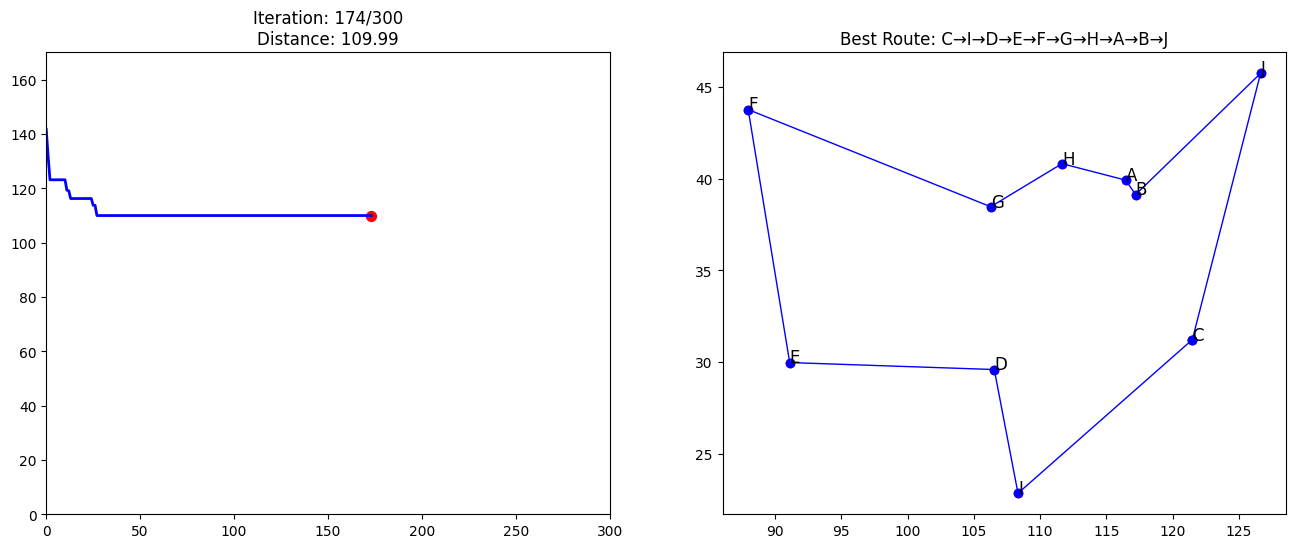

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 城市坐标和名称
x = [116.46, 117.2, 121.48, 106.54, 91.11, 87.98, 106.27, 111.65, 108.33, 126.63]
y = [39.92, 39.13, 31.22, 29.59, 29.97, 43.77, 38.47, 40.82, 22.84, 45.75]
city_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
n_cities = len(x)

# 计算距离矩阵
distance_matrix = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(n_cities):
        dx = x[i] - x[j]
        dy = y[i] - y[j]
        distance_matrix[i][j] = np.sqrt(dx**2 + dy**2)

def calculate_total_distance(order):
    return sum(distance_matrix[order[i], order[(i+1)%n_cities]] for i in range(n_cities))

class PSO_TSP:
    def __init__(self, n_particles=50, max_iter=300):
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.history = []
        
        # 初始化粒子群
        self.particles = [self.create_particle() for _ in range(n_particles)]
        self.gbest_position = None
        self.gbest_value = float('inf')

    def create_particle(self):
        perm = np.random.permutation(n_cities)
        position = perm.argsort().astype(float)
        position += np.random.normal(0, 0.1, n_cities)
        return {
            'position': position,
            'velocity': np.zeros(n_cities),
            'pbest_position': position.copy(),
            'pbest_value': float('inf')
        }

    def update(self, iter):
        w = 0.9 - 0.5 * iter / self.max_iter  # 惯性权重
        c1 = c2 = 2.0  # 学习因子
        
        # 更新个体最优和全局最优
        for p in self.particles:
            order = np.argsort(p['position'])
            current_value = calculate_total_distance(order)
            
            if current_value < p['pbest_value']:
                p['pbest_value'] = current_value
                p['pbest_position'] = p['position'].copy()
                
            if current_value < self.gbest_value:
                self.gbest_value = current_value
                self.gbest_position = p['position'].copy()
        
        # 更新粒子速度和位置
        for p in self.particles:
            r1, r2 = np.random.rand(n_cities), np.random.rand(n_cities)
            p['velocity'] = w*p['velocity'] + \
                           c1*r1*(p['pbest_position'] - p['position']) + \
                           c2*r2*(self.gbest_position - p['position'])
            p['position'] += p['velocity']
            
            # 10%概率进行变异
            if np.random.rand() < 0.1:
                i, j = np.random.choice(n_cities, 2, False)
                p['position'][[i, j]] = p['position'][[j, i]]
        
        # 记录历史最优解
        best_order = np.argsort(self.gbest_position)
        self.history.append({
            'iteration': iter,
            'distance': self.gbest_value,
            'path': best_order
        })

# 创建优化器并运行
pso = PSO_TSP(n_particles=50, max_iter=300)
for iter in range(pso.max_iter):
    pso.update(iter)

# 动画生成设置
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

def init():
    ax1.set_xlim(0, pso.max_iter)
    ax1.set_ylim(0, pso.history[0]['distance']*1.2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Distance')
    ax1.set_title('Optimization Progress')
    
    ax2.scatter(x, y, c='red', zorder=2)
    for i, name in enumerate(city_names):
        ax2.annotate(name, (x[i], y[i]), fontsize=12)
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_title('Best Route')
    return fig,

def animate(i):
    # 清空之前绘制的内容
    ax1.clear()
    ax2.clear()
    
    # 绘制优化曲线
    iterations = [h['iteration'] for h in pso.history[:i+1]]
    distances = [h['distance'] for h in pso.history[:i+1]]
    ax1.plot(iterations, distances, 'b-', linewidth=2)
    ax1.scatter(iterations[-1], distances[-1], c='r', s=50)
    ax1.set_xlim(0, pso.max_iter)
    ax1.set_ylim(0, pso.history[0]['distance']*1.2)
    ax1.set_title(f'Iteration: {i+1}/{pso.max_iter}\nDistance: {distances[-1]:.2f}')
    
    # 绘制路径
    path = pso.history[i]['path']
    path_x = [x[i] for i in path] + [x[path[0]]]
    path_y = [y[i] for i in path] + [y[path[0]]]
    
    ax2.scatter(x, y, c='red', zorder=2)
    for i, name in enumerate(city_names):
        ax2.annotate(name, (x[i], y[i]), fontsize=12)
    ax2.plot(path_x, path_y, 'b-o', linewidth=1, markersize=6)
    ax2.set_title(f'Best Route: {"→".join([city_names[i] for i in path])}')
    
    return fig,

# 生成动画
ani = FuncAnimation(fig, animate, frames=len(pso.history),
                    init_func=init, blit=True, interval=100)

# 保存为GIF（需要安装ImageMagick）
ani.save('tsp_optimization.gif', writer='imagemagick', fps=15)

# 显示动画
plt.show()